In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torchvision import models, transforms
from PIL import Image
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

content = "../data/garden.jpg"
style_p = "../data/picasso.jpg"
style_v = "../data/starry.jpeg"

style = style_p

# specific to the vgg train so our data must match the normalization
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [7]:
# Data pipeline

trans = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()
])


## Helper functions

def img_load(path):
    I = Image.open(path)
    I = trans(I).unsqueeze(0)
    return I.to(device, torch.float)

def save_img(tensor, path):
    T = tensor.cpu().clone()
    I = transforms.ToPILImage()(T.squeeze(0))
    plt.imshow(I)
    plt.savefig(path)
    return I

def show_img(tensor):
    T = tensor.cpu().clone()
    I = transforms.ToPILImage()(T.squeeze(0))
    plt.imshow(I)
    plt.show(I)

content_img = img_load(content)
style_img = img_load(style)

assert style_img.size() == content_img.size()

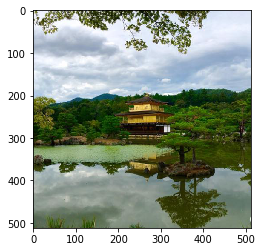

In [8]:
# Display content
show_img(content_img)

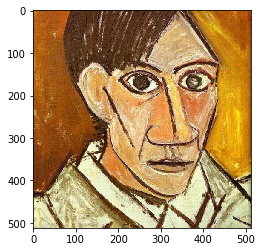

In [9]:
# Display style
show_img(style_img)

In [10]:
# Loss Definition

class ContentLoss(nn.Module):
    """ ContentLoss module, designed to integrate into
    the VGG19 net. 
    """
    def __init__(self, target_img):
        super(ContentLoss, self).__init__()
        self.target_img = target_img.detach()
    
    def forward(self, inp_img):
        # Computes mean squared error loss between input image and the
        # target content image. 
        self.loss = nn.functional.mse_loss(inp_img, self.target_img)
        return inp_img
        
class StyleLoss(nn.Module):
    """ StyleLoss module, designed to integrate into
    the VGG19 net. 
    """
    def __init__(self, target_img):
        super(StyleLoss, self).__init__()
        batch, k, m, n = target_img.size()
        gram = gram_calc(target_img.view(batch * k, m * n))
        self.target_img = gram.detach()
    
    def forward(self, inp_img):
        # Computes MSE loss between the gram of the input image 
        # and the gram of the target style image
        batch, k, m, n = inp_img.size()
        gram = gram_calc(inp_img.view(batch * k, m * n))
        self.loss = nn.functional.mse_loss(gram, self.target_img)
        return inp_img
        

class Normalization(nn.Module):
    """ Implements the normalization needed for the
    VGG19 net
    """
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        if type(mean) != torch.Tensor:
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)
        else:
            self.mean = mean.view(-1, 1, 1)
            self.std = std.view(-1, 1, 1)
    
    def forward(self, inp_img):
        return (inp_img - self.mean) / self.std    

# Helper functions

def gram_calc(tensor):
    """ Calculates the Gram matrix for the given input 
        Input:
            tensor :: Pytorch tensor
        Output: 
            gram :: Pytorch tensor
    """
    size = tensor.size()
    size_prod = size[0] * size[1]
    gram = torch.mm(tensor, tensor.t()).div(size_prod)
    return gram

In [11]:
# Model building

cnn = models.vgg19(pretrained=True).features.to(device).eval()

def build_model(cnn, norm_mean, norm_std, style_img, content_img,
                content_layers=content_layers_default, 
                style_layers=style_layers_default):
    """ Builds the model from the VGG19 pretrained model
    Inputs:
        cnn :: Pretrained CNN model
        norm_mean, norm_std :: Pytorch tensor
        style_img, content_img :: Pytorch tensor
        content_layers, style_layers :: List
    Outputs:
        model :: Modified model with transparent loss layers added
        content_loss_obj :: Content loss objects
        style_loss_obj :: Style loss objects
    """
    
    cnn = deepcopy(cnn)
    norm = Normalization(norm_mean, norm_std).to(device)
    model = nn.Sequential(norm)
    
    content_loss_obj = []
    style_loss_obj = []
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_{}".format(i)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "batchnorm_{}".format(i)
        else:
            raise RuntimeError("Layer not recognized: {}".format(layer.__class__.__name__))
        
        # Add to the model
        model.add_module(name, layer)
        
        # check if losses need to be added
        if name in content_layers:
            target_img = model(content_img).detach()
            content_loss = ContentLoss(target_img)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_loss_obj.append(content_loss)
        
        if name in style_layers:
            target_img = model(style_img).detach()
            style_loss = StyleLoss(target_img)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_loss_obj.append(style_loss)
    
    # iterate backwards and keep everything up until last loss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            model = model[:(i+1)]
            break
    
    return model, content_loss_obj, style_loss_obj

In [20]:
# Model training

def train_model(cnn, norm_mean, norm_std, content_img, style_img,
                input_img, num_iter=300, style_weight=10e6, content_weight=1,
                content_layers=content_layers_default,
                style_layers=style_layers_default):
    """ Trains the model to optimize input image to minimize total loss
    Input:
        cnn :: Pretrained CNN model
        norm_mean, norm_std :: Pytorch tensor
        style_img, content_img, input_img :: Pytorch tensor
        content_layers, style_layers :: List
        style_weight, content_weight :: Float
        num_iter :: Integer
    Output:
        input_img :: Pytorch tensor 
        c_loss_history, s_loss_history :: List
    """
    
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    
    model, c_loss, s_loss = build_model(cnn, norm_mean, norm_std, 
                                        style_img, content_img,
                                       content_layers, style_layers)
    c_loss_history = []
    s_loss_history = []
    print("Training...")
    run = [0]
    while run[0] <= num_iter:
        def closure():
            input_img.data.clamp_(0,1)
            
            optimizer.zero_grad()
            model(input_img)
            s_score = 0
            c_score = 0
            
            for sl in s_loss:
                s_score += sl.loss
            for cl in c_loss:
                c_score += cl.loss
                
            c_loss_history.append(c_score)
            s_loss_history.append(s_score)
                
            s_score *= style_weight
            c_score *= content_weight
            
            loss = s_score + c_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}".format(run))
                print("Loss: {:4f}".format(loss.item()))
                print()
            
            return s_score + c_score 
        optimizer.step(closure)
    
    input_img.data.clamp(0,1)
    return input_img, c_loss_history, s_loss_history

In [21]:
input_img_clone = content_img.clone()
output_clone, c_loss_history, s_loss_history = train_model(cnn, cnn_normalization_mean, cnn_normalization_std,
                    content_img, style_img, input_img_clone)

Training...
run [50]
Loss: 947.384827

run [100]
Loss: 192.078369

run [150]
Loss: 78.831886

run [200]
Loss: 46.753994

run [250]
Loss: 33.652668

run [300]
Loss: 27.969841



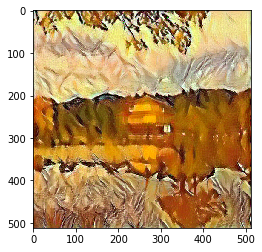

In [22]:
show_img(output_clone)

In [28]:
# Plotting training loss

num_iter = np.arange(320)
cx = np.array([tensor.cpu().item() for tensor in c_loss_history])
sx = np.array([tensor.cpu().item() for tensor in s_loss_history])

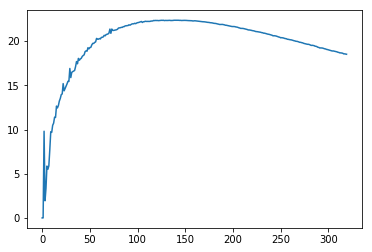

In [30]:
plt.plot(num_iter, cx)

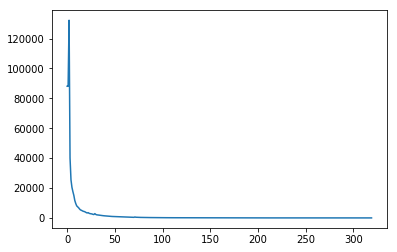

In [31]:
plt.plot(num_iter, sx)